# Quantum Mechanics Wave Evolution
a 1 dimensional wave evolves through time according to the time dependent equation

$$
j \hbar \frac{\partial \psi}{\partial t} = H \psi
$$

with Crank-Nicholson method we take an average of the explicit and the implicit time stepping when we discretize:

$$
j \hbar \frac{\psi^{t+1}_x - \psi^{t}_x}{\Delta t} = \frac{1}{2} H \psi^{t+1}_x + \frac{1}{2} H \psi^{t}_x
$$

pd: $\hbar = 1$

where $H$ is the Hamiltonian, expressed as:

$$
H = - \frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V
$$

2nd order derivative is discretized as:

$$
\frac{\partial^2 \psi^t_x}{\partial x^2} = \frac{\psi^t_{x+1} - 2 \psi^t_x + \psi^t_{x-1}}{(\Delta x)^2} = \frac{D^2}{(\Delta x)^2} \psi^t_x
$$

the discretization of the 2nd order derivative ends up as a matrix:

$$
D^2 = \left( \begin{matrix} 
-2 && 1 && 0 && 0 && \dots && 0 && 0 \\
1 && -2 && 1 && 0 && \dots && 0 && 0 \\
0 && 1 && -2 && 1 && \dots && 0 && 0 \\
0 && 0 && 1 && -2 && \dots && 0 && 0 \\
\vdots && \vdots && \vdots && \vdots && \ddots && \vdots && \vdots \\
0 && 0 && 0 && 0 && \dots && -2 && 1 \\
0 && 0 && 0 && 0 && \dots && 1 && -2 \\
\end{matrix} \right)
$$

Solving for the next iteration of $\psi$

$$
\psi_x^{t+1} = (u + D^2 - \beta V)^{-1} (u - D^2 + \beta V) \psi_x^t
$$

In [22]:
import torch
import torch.nn as nn
import numpy as np

from scipy import sparse

import matplotlib.pyplot as plt


In [20]:
# Potential V(x)
x_Vmin = 5         # center of V(x)
T      = 1           # peroid of SHO 

omega = 2 * np.pi / T
k = omega**2 * m
V = 0.5 * k * (x - x_Vmin)**2


In [17]:
dx    = 0.02                      # spatial separation
x     = np.arange(0, 10, dx)       # spatial grid points

kx    = 0.1                        # wave number
m     = 1                          # mass
sigma = 0.1                        # width of initial gaussian wave-packet
x0    = 3.0                        # center of initial gaussian wave-packet

A = 1.0 / (sigma * np.sqrt(np.pi)) # normalization constant

# Initial Wavefunction
psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)

# better than defining a new tensor, is to recast
psi_wp = torch.as_tensor(psi0, dtype=torch.cfloat)

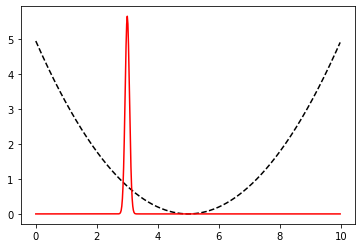

In [21]:
# wave packet
plt.plot(x, V*0.01, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, np.abs(psi_wp)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.show()

In [29]:
# evolution
m = 1
hbar = 1
dt = 0.5

u = 1j * 4*m* dx**2 / ( hbar * dt )
beta = 2*m* dx**2 / hbar**2

# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

D2.toarray()*dx**2

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [31]:
D2.dot(psi0).sum()

(-3.4223058414939445e-13+1.23936885060294e-13j)

In [33]:
D2t = torch.as_tensor(D2.toarray())

In [35]:
D2t.dot(psi_wp)

RuntimeError: 1D tensors expected, but got 2D and 1D tensors

In [36]:
torch.matmul(D2t, psi_wp)

RuntimeError: expected scalar type Double but found ComplexFloat

In [37]:
torch.einsum('ij,j->i', D2t, psi_wp)

RuntimeError: expected scalar type ComplexFloat but found Double

In [38]:
D2t = torch.as_tensor(D2.toarray(), dtype = torch.cfloat)

In [40]:
torch.einsum('ij,j->i', D2t, psi_wp).sum()

tensor(0.0007+0.0004j)